In [1]:
import sys
import datetime as dt
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load SPL Data

In [2]:
### GET CLEAN SPL DATA 

master_df = pd.read_csv(config.dataFol+'clean_spl/clean_spl.csv')

### Data Processing 

* Convert UTC -> EST for easy understanding 

In [3]:
### Convert UTC TO EST 
master_df['timestamp_est'] = pd.to_datetime(master_df['timestamp'])


In [4]:
### check to see if the timestamp is aware

master_df['timestamp_est'].dt.tz


In [5]:
## call it UTC time 
master_df['timestamp_est'] = master_df['timestamp_est'].dt.tz_localize('UTC')

In [6]:
### Convert it to EST 
master_df['timestamp_est'] = master_df['timestamp_est'].dt.tz_convert('US/Eastern')

In [7]:
master_df.head()

,timestamp,sonyc_sensor_id,sonyc_sensor_name,dBAS_lin_mean,l1,l10,l5,l90,timestamp_est
0,2019-01-01 07:58,sonycnode-b827eb815321.sonyc,19 Washington Square North,70.687070,77.1220,74.240,75.640000,60.990,2019-01-01 02:58:00-05:00
1,2019-01-01 07:59,sonycnode-b827eb815321.sonyc,19 Washington Square North,67.926040,76.8500,72.830,74.890000,58.950,2019-01-01 02:59:00-05:00
2,2019-01-01 08:00,sonycnode-b827eb815321.sonyc,19 Washington Square North,62.928024,71.3515,66.717,69.471504,58.017,2019-01-01 03:00:00-05:00
3,2019-01-01 08:01,sonycnode-b827eb815321.sonyc,19 Washington Square North,69.372770,75.0568,73.352,74.281000,59.306,2019-01-01 03:01:00-05:00
4,2019-01-01 08:02,sonycnode-b827eb815321.sonyc,19 Washington Square North,65.137650,74.9555,68.508,72.521996,58.290,2019-01-01 03:02:00-05:00


### Filter for the Target Spring Period (2017-03-01  -> 2020-05-31)

These dates are the basis of our analysis (key months for spring migration) in the New York City area where we expect to see the most number of diverse species and the highest density of bird vocalizations. 

In [8]:
spring_df = master_df[(master_df['timestamp_est'] >= '2017-03-01') & (master_df['timestamp_est'] < '2017-05-31') |\
                      (master_df['timestamp_est'] >= '2018-03-01') & (master_df['timestamp_est'] < '2018-05-31') |\
                      (master_df['timestamp_est'] >= '2019-03-01') & (master_df['timestamp_est'] < '2019-05-31') |\
                      (master_df['timestamp_est'] >= '2020-03-01') & (master_df['timestamp_est'] < '2020-05-31')] 

In [9]:
spring_df.sort_values(by = ['timestamp_est'])

,timestamp,sonyc_sensor_id,sonyc_sensor_name,dBAS_lin_mean,l1,l10,l5,l90,timestamp_est
8230161,2017-03-01 05:00,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,60.979420,66.171000,63.572000,64.620000,58.089,2017-03-01 00:00:00-05:00
6555549,2017-03-01 05:00,sonycnode-b827eb0fedda.sonyc,Juan Carlos,63.368927,76.138600,63.765000,65.956500,54.859,2017-03-01 00:00:00-05:00
571744,2017-03-01 05:00,sonycnode-b827eb815321.sonyc,19 Washington Square North,60.607727,68.480995,65.925995,66.921500,54.259,2017-03-01 00:00:00-05:00
3720820,2017-03-01 05:00,sonycnode-b827eb86d458.sonyc,Silver lab,65.882920,75.712204,69.303000,72.051506,57.176,2017-03-01 00:00:00-05:00
571745,2017-03-01 05:01,sonycnode-b827eb815321.sonyc,19 Washington Square North,63.273500,70.980995,66.994995,68.761505,54.520,2017-03-01 00:01:00-05:00
...,...,...,...,...,...,...,...,...,...
7724735,2020-05-31 03:57,sonycnode-b827eb0fedda.sonyc,Juan Carlos,57.976265,59.704200,58.830000,59.122498,56.949,2020-05-30 23:57:00-04:00
1652219,2020-05-31 03:58,sonycnode-b827eb815321.sonyc,19 Washington Square North,58.529602,60.287700,59.210000,59.510000,57.779,2020-05-30 23:58:00-04:00
7724736,2020-05-31 03:58,sonycnode-b827eb0fedda.sonyc,Juan Carlos,58.577415,61.316300,60.180000,60.580000,57.188,2020-05-30 23:58:00-04:00
1652220,2020-05-31 03:59,sonycnode-b827eb815321.sonyc,19 Washington Square North,58.392937,59.830000,59.000000,59.270500,57.669,2020-05-30 23:59:00-04:00


In [10]:
### DOUBLE CHECK THESE VALUES - 
spring_df['year_est'] = pd.DatetimeIndex(spring_df['timestamp_est']).year
spring_df['month_est'] = pd.DatetimeIndex(spring_df['timestamp_est']).month
spring_df['week_est'] = pd.DatetimeIndex(spring_df['timestamp_est']).week
spring_df['dayofweek_est'] = pd.DatetimeIndex(spring_df['timestamp_est']).dayofweek
spring_df['day_est'] = pd.DatetimeIndex(spring_df['timestamp_est']).day
spring_df['hour_est'] = pd.DatetimeIndex(spring_df['timestamp_est']).hour


/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

### EXPLORE DATA - Find the lowest decibel levels for a weekly average 

In [11]:
spring_df.tail()

,timestamp,sonyc_sensor_id,sonyc_sensor_name,dBAS_lin_mean,l1,l10,l5,l90,timestamp_est,year_est,month_est,week_est,dayofweek_est,day_est,hour_est
9253456,2020-05-31 02:19,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,66.316750,75.407900,70.273994,72.511,59.850000,2020-05-30 22:19:00-04:00,2020,5,22,5,30,22
9253457,2020-05-31 02:20,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,67.029950,75.342600,69.953000,72.560,62.325000,2020-05-30 22:20:00-04:00,2020,5,22,5,30,22
9253458,2020-05-31 02:21,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,65.996610,71.302895,67.861000,68.652,63.398003,2020-05-30 22:21:00-04:00,2020,5,22,5,30,22
9253459,2020-05-31 02:22,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,63.701878,66.787300,64.841995,65.420,62.398003,2020-05-30 22:22:00-04:00,2020,5,22,5,30,22
9253460,2020-05-31 02:23,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,64.980640,70.995000,66.160000,67.675,63.010000,2020-05-30 22:23:00-04:00,2020,5,22,5,30,22


In [12]:
#master_df.sort_values(by = ["timestamp"])

In [13]:
spring_df.nlargest(10, ['dBAS_lin_mean'])

,timestamp,sonyc_sensor_id,sonyc_sensor_name,dBAS_lin_mean,l1,l10,l5,l90,timestamp_est,year_est,month_est,week_est,dayofweek_est,day_est,hour_est
4208752,2018-04-04 16:41,sonycnode-b827eb86d458.sonyc,Silver lab,103.628770,112.558900,109.191000,111.262000,67.195,2018-04-04 12:41:00-04:00,2018,4,14,2,4,12
8252513,2017-03-16 17:46,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,103.389970,112.804700,109.393000,111.566500,70.369,2017-03-16 13:46:00-04:00,2017,3,11,3,16,13
7712425,2020-05-22 14:47,sonycnode-b827eb0fedda.sonyc,Juan Carlos,101.636050,108.213196,106.173996,107.471000,94.608,2020-05-22 10:47:00-04:00,2020,5,21,4,22,10
6635271,2017-04-25 13:42,sonycnode-b827eb0fedda.sonyc,Juan Carlos,101.098770,105.579410,103.364000,104.312996,96.959,2017-04-25 09:42:00-04:00,2017,4,17,1,25,9
7854261,2019-04-25 19:17,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,100.818320,110.606300,105.870000,108.076996,73.208,2019-04-25 15:17:00-04:00,2019,4,17,3,25,15
7838979,2019-04-14 16:48,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,100.333740,109.994200,106.591995,108.103000,65.705,2019-04-14 12:48:00-04:00,2019,4,15,6,14,12
6597754,2017-03-30 12:25,sonycnode-b827eb0fedda.sonyc,Juan Carlos,100.332405,104.570496,103.873000,104.240500,79.597,2017-03-30 08:25:00-04:00,2017,3,13,3,30,8
4250365,2018-05-03 14:14,sonycnode-b827eb86d458.sonyc,Silver lab,99.815000,112.110400,102.937000,107.100500,78.348,2018-05-03 10:14:00-04:00,2018,5,18,3,3,10
7839253,2019-04-14 21:22,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,99.804060,111.471504,104.393000,107.840500,65.929,2019-04-14 17:22:00-04:00,2019,4,15,6,14,17
7837290,2019-04-13 12:39,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room,99.427300,104.862100,103.951000,104.240000,85.177,2019-04-13 08:39:00-04:00,2019,4,15,5,13,8


In [14]:
spring_df.nsmallest(10, ['dBAS_lin_mean'])

,timestamp,sonyc_sensor_id,sonyc_sensor_name,dBAS_lin_mean,l1,l10,l5,l90,timestamp_est,year_est,month_est,week_est,dayofweek_est,day_est,hour_est
3340342,2019-04-05 18:32,sonycnode-b827eb86d458.sonyc,Silver lab,44.704918,50.725002,47.285000,49.105000,40.790000,2019-04-05 14:32:00-04:00,2019,4,14,4,5,14
3340324,2019-04-05 18:05,sonycnode-b827eb86d458.sonyc,Silver lab,46.845108,56.117100,49.212997,51.126000,42.779000,2019-04-05 14:05:00-04:00,2019,4,14,4,5,14
3340328,2019-04-05 18:14,sonycnode-b827eb86d458.sonyc,Silver lab,47.044277,52.352398,49.040000,49.614000,43.992000,2019-04-05 14:14:00-04:00,2019,4,14,4,5,14
577820,2017-03-05 10:16,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.333153,49.428400,48.991000,49.150500,47.609000,2017-03-05 05:16:00-05:00,2017,3,9,6,5,5
1551616,2020-03-22 07:15,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.346107,50.054703,49.130000,49.380000,47.460000,2020-03-22 03:15:00-04:00,2020,3,12,6,22,3
577817,2017-03-05 10:13,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.373840,49.682100,49.221000,49.420498,47.519000,2017-03-05 05:13:00-05:00,2017,3,9,6,5,5
577821,2017-03-05 10:17,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.659050,50.036800,49.400000,49.620000,47.838000,2017-03-05 05:17:00-05:00,2017,3,9,6,5,5
119296,2019-03-27 08:40,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.723637,49.826800,49.400000,49.541000,47.980000,2019-03-27 04:40:00-04:00,2019,3,13,2,27,4
1551612,2020-03-22 07:11,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.779484,51.320000,50.072998,50.591000,47.649002,2020-03-22 03:11:00-04:00,2020,3,12,6,22,3
579110,2017-03-06 07:46,sonycnode-b827eb815321.sonyc,19 Washington Square North,48.808308,50.033000,49.566000,49.740000,48.010000,2017-03-06 02:46:00-05:00,2017,3,10,0,6,2


In [15]:
spring_df.describe()

,dBAS_lin_mean,l1,l10,l5,l90,year_est,month_est,week_est,dayofweek_est,day_est,hour_est
count,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06,2.472184e+06
mean,6.238570e+01,6.876485e+01,6.456273e+01,6.609176e+01,5.810117e+01,2.018446e+03,3.958573e+00,1.538177e+01,3.007234e+00,1.559234e+01,1.148954e+01
std,5.332318e+00,6.836692e+00,5.657329e+00,6.053610e+00,4.413007e+00,1.135372e+00,8.215227e-01,3.767911e+00,1.997039e+00,8.681402e+00,6.917060e+00
min,4.470492e+01,4.942840e+01,4.728500e+01,4.910500e+01,4.079000e+01,2.017000e+03,3.000000e+00,9.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.864389e+01,6.424990e+01,6.057100e+01,6.196200e+01,5.502000e+01,2.017000e+03,3.000000e+00,1.200000e+01,1.000000e+00,8.000000e+00,5.000000e+00
50%,6.185988e+01,6.852890e+01,6.431200e+01,6.589850e+01,5.756700e+01,2.018000e+03,4.000000e+00,1.500000e+01,3.000000e+00,1.600000e+01,1.100000e+01
75%,6.535797e+01,7.270930e+01,6.781499e+01,6.949150e+01,6.035000e+01,2.019000e+03,5.000000e+00,1.900000e+01,5.000000e+00,2.300000e+01,1.700000e+01
max,1.036288e+02,1.128047e+02,1.093930e+02,1.115665e+02,9.696300e+01,2.020000e+03,5.000000e+00,2.200000e+01,6.000000e+00,3.100000e+01,2.300000e+01


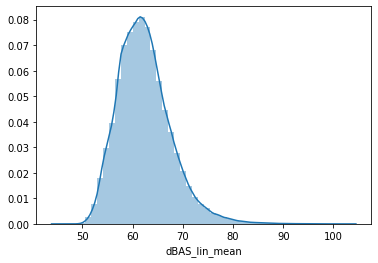

In [16]:
sns.distplot(spring_df.dBAS_lin_mean)


### PLOT DATA EXPLORATION


In [17]:
spring_df_2017 = spring_df[(spring_df['timestamp'] >= '2017-03-01') & (spring_df['timestamp'] < '2017-05-31')]

spring_df_2018 = spring_df[(spring_df['timestamp'] >= '2018-03-01') & (spring_df['timestamp'] < '2018-05-31')]

spring_df_2019 = spring_df[(spring_df['timestamp'] >= '2019-03-01') & (spring_df['timestamp'] < '2019-05-31')]

spring_df_2020 = spring_df[(spring_df['timestamp'] >= '2020-03-01') & (spring_df['timestamp'] < '2020-05-31')]

In [18]:
#hour_dbas_2017 = spring_df_2017.groupby(['hour_est']).mean()['dBAS_lin_mean']
#hour_dbas.head()

In [19]:
#hour_dbas.plot(color='lightblue', figsize=(15, 8))
#plt.title('dBAS_lin_mean Average by Hour (EST) 2017 from March - May', fontsize=12)
#plt.ylabel('dBAS_lin_mean')

In [20]:
### Break them up into seperate year and mean by the hour
hour_dbas_test = spring_df.groupby(['year_est', 'hour_est']).mean()#['dBAS_lin_mean']
hour_dbas_test.reset_index().pivot(index='hour_est', columns='year_est', values='dBAS_lin_mean')


year_est,2017,2018,2019,2020
hour_est,,,,
0,61.181044,60.305094,59.184503,58.005588
1,60.235578,59.297823,58.416523,57.831450
2,59.705574,58.586569,57.626358,57.549190
3,59.405154,58.332032,57.359522,57.532187
4,59.157806,58.377577,57.370381,57.691175
5,60.458487,59.733481,58.975775,59.046832
6,61.991883,60.830020,60.070180,60.020102
7,65.936646,63.201481,63.881975,60.741988
8,66.802240,63.916626,65.011979,61.318090


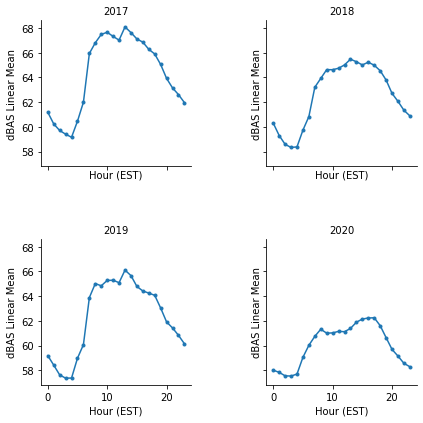

In [21]:
g = sns.FacetGrid(hour_dbas_test.reset_index(), col="year_est", col_wrap=2, height=3)
g = g.map(plt.plot, "hour_est", "dBAS_lin_mean", marker=".")
g.set(xlabel='Hour (EST)', ylabel='dBAS Linear Mean').set_titles("{col_name}").fig.subplots_adjust(wspace=.5, hspace=.5)

In [22]:
#hourly_averages.dtypes

In [23]:
hour_dbas_month = spring_df.groupby(['month_est', 'hour_est']).mean()#['dBAS_lin_mean']
hour_dbas_month.reset_index().pivot(index='hour_est', columns='month_est', values='dBAS_lin_mean')


month_est,3,4,5
hour_est,,,
0,59.884206,59.686248,59.580990
1,59.249106,59.015195,58.677767
2,58.657377,58.462580,58.097997
3,58.469038,58.221953,57.867634
4,58.200472,58.217421,58.125090
5,58.855469,59.684003,60.304151
6,60.575375,60.885126,60.879122
7,63.574799,63.361565,63.631548
8,64.415041,64.244273,64.373523


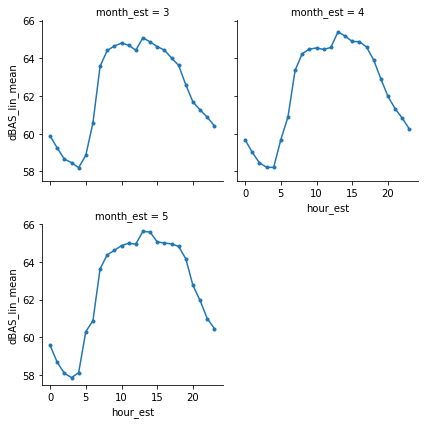

In [24]:
## Graph the each sensor by month 
g = sns.FacetGrid(hour_dbas_month.reset_index(), col="month_est", col_wrap=2, height=3)
g = g.map(plt.plot, "hour_est", "dBAS_lin_mean", marker=".")

In [25]:
### GRAPH BY SENSOR BY HOUR 

In [26]:
hour_dbas_sensor = spring_df.groupby(['sonyc_sensor_name', 'hour_est']).mean()#['dBAS_lin_mean']
hour_dbas_sensor.reset_index().pivot(index='hour_est', columns='sonyc_sensor_name', values='dBAS_lin_mean')


sonyc_sensor_name,19 Washington Square North,4 Washington Square North,Juan Carlos,Kimmel Center,Shimkin Reading Room,Silver lab
hour_est,,,,,,
0,60.529494,57.677067,59.029311,58.420131,62.071534,61.197778
1,59.968090,56.880940,58.415771,57.670386,61.448685,59.895954
2,59.194488,56.346931,57.927570,57.142988,60.932013,59.199166
3,58.720651,56.161304,57.769915,56.929500,60.931096,58.892066
4,58.354403,56.276683,57.900181,57.022468,60.916759,58.890526
5,59.827217,57.973442,59.382341,58.446309,61.774883,60.271350
6,60.750254,59.132901,60.438320,59.431245,63.069300,62.306370
7,62.015258,62.373369,63.264870,62.380543,65.509225,66.961318
8,63.006687,62.893905,64.662425,63.256925,66.153271,67.149234


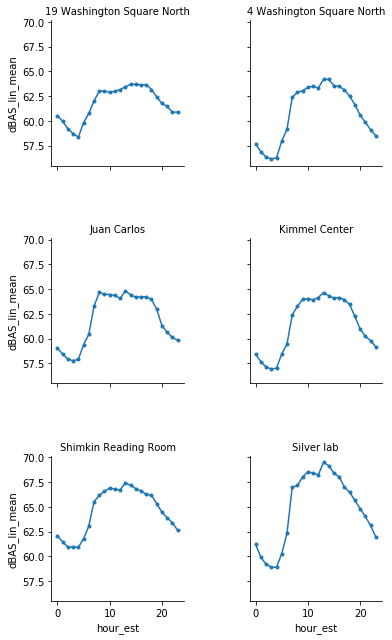

In [27]:
g = sns.FacetGrid(hour_dbas_sensor.reset_index(), col="sonyc_sensor_name", col_wrap=2, height=3)
g = g.map(plt.plot, "hour_est", "dBAS_lin_mean", marker=".").set_titles("{col_name}").fig.subplots_adjust(wspace=.5, hspace=.5)

In [28]:
#### Monthly Exploration

hour_dbas_week = spring_df.groupby(['week_est','hour_est']).mean()#['dBAS_lin_mean']
hour_dbas_week.reset_index().pivot(index='hour_est', columns='week_est', values='dBAS_lin_mean')


week_est,9,10,11,12,13,14,15,16,17,18,19,20,21,22
hour_est,,,,,,,,,,,,,,
0,62.005107,60.291185,59.842923,59.129121,59.885840,59.102140,59.474038,59.646897,60.229518,59.904681,59.665138,59.503603,59.651284,58.375975
1,61.563060,59.707007,58.978003,58.592697,59.103209,58.474893,58.743605,59.303911,59.350445,59.220498,58.669365,58.557425,58.637106,57.711666
2,60.529878,58.985289,58.283784,57.995523,58.999636,58.200975,58.092184,58.828265,58.631131,58.544472,57.981239,57.971496,58.126110,57.327912
3,59.690777,58.988684,58.069179,57.984561,58.545387,58.102348,57.935197,58.459908,58.279827,58.382374,57.771456,57.851884,57.927834,56.944726
4,58.806173,58.570209,57.611765,57.934717,58.576363,57.575079,58.237102,58.495628,58.405821,58.391189,58.030178,58.125195,58.201833,57.809888
5,59.071734,59.243831,58.491037,58.395639,59.170833,58.611845,59.629430,60.192458,60.352532,60.336377,60.129276,60.468079,60.480991,59.804541
6,60.778575,61.054660,59.942530,60.327678,60.775561,60.190460,60.802602,61.432002,61.246684,61.343671,60.602255,60.891730,61.325356,59.800711
7,63.343635,63.819473,63.272046,63.529241,63.747018,63.060859,63.011492,63.931423,63.634222,63.992984,63.110332,63.616363,64.136148,62.733293
8,64.274809,64.535742,64.162665,64.440886,64.795388,64.193699,63.782617,64.833725,64.073827,65.201487,63.854970,64.245029,64.628497,63.384553


In [29]:
### Day by Day Analysis of Sound Pressure Level Data 

In [30]:
hour_dbas_daybyday = spring_df.groupby(['timestamp_est']).mean()#['dBAS_lin_mean']
hour_dbas_daybyday.head()

,dBAS_lin_mean,l1,l10,l5,l90,year_est,month_est,week_est,dayofweek_est,day_est,hour_est
timestamp_est,,,,,,,,,,,
2017-03-01 00:00:00-05:00,62.709749,71.625700,65.641499,67.387377,56.095750,2017,3,9,2,1,0
2017-03-01 00:01:00-05:00,63.769958,71.755474,67.313249,69.027002,56.527500,2017,3,9,2,1,0
2017-03-01 00:02:00-05:00,58.879610,64.775125,61.566499,63.154624,55.392250,2017,3,9,2,1,0
2017-03-01 00:03:00-05:00,59.805411,66.243975,62.935999,63.891625,55.900251,2017,3,9,2,1,0
2017-03-01 00:04:00-05:00,60.251264,66.455750,63.113000,64.047503,55.843751,2017,3,9,2,1,0


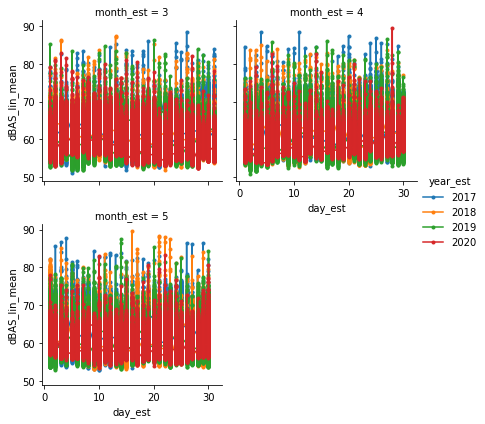

In [31]:
g = sns.FacetGrid(hour_dbas_daybyday, hue="year_est",
                  col="month_est", col_wrap=2, height=3)
g = (g.map(plt.plot, "day_est", "dBAS_lin_mean", marker=".").add_legend())

In [32]:
hour_dbas_daybyday.dtypes

dBAS_lin_mean    float64
l1               float64
l10              float64
l5               float64
l90              float64
year_est           int64
month_est          int64
week_est           int64
dayofweek_est      int64
day_est            int64
hour_est           int64
dtype: object

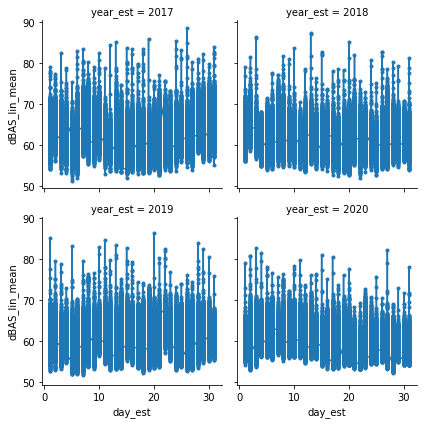

In [33]:
### Annual SPL data March

g = sns.FacetGrid(hour_dbas_daybyday[hour_dbas_daybyday['month_est']==3],
                  col="year_est", col_wrap=2, height=3)
g = (g.map(plt.plot, "day_est", "dBAS_lin_mean", marker="."))

In [34]:
#### Annual SPL data April 

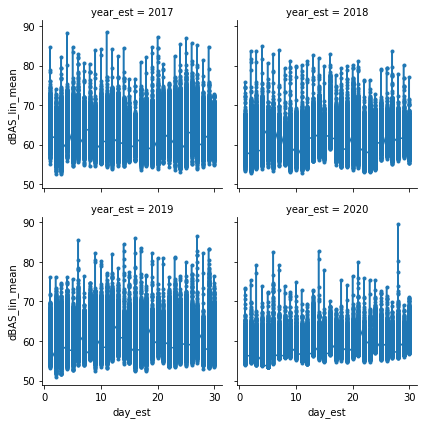

In [35]:
g = sns.FacetGrid(hour_dbas_daybyday[hour_dbas_daybyday['month_est']==4],
                  col="year_est", col_wrap=2, height=3)
g = (g.map(plt.plot, "day_est", "dBAS_lin_mean", marker="."))

In [36]:
### Annual dBAS Level May 

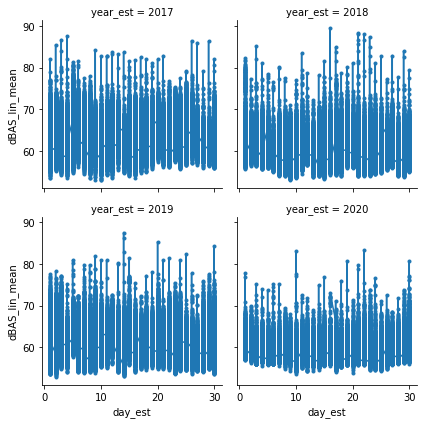

In [37]:
g = sns.FacetGrid(hour_dbas_daybyday[hour_dbas_daybyday['month_est']==5],
                  col="year_est", col_wrap=2, height=3)
g = (g.map(plt.plot, "day_est", "dBAS_lin_mean", marker="."))

### Timeseries - Seasonal Decomposition

In [38]:
spring_df_list = dict(list(spring_df.groupby('sonyc_sensor_name')))
for key in spring_df_list.keys():
    spring_df_list[key] = spring_df_list[key].set_index('timestamp_est')
    spring_df_list[key] = spring_df_list[key][['year_est', 'dBAS_lin_mean']].copy()

In [39]:
plt.rcParams['figure.figsize'] = [7, 5]

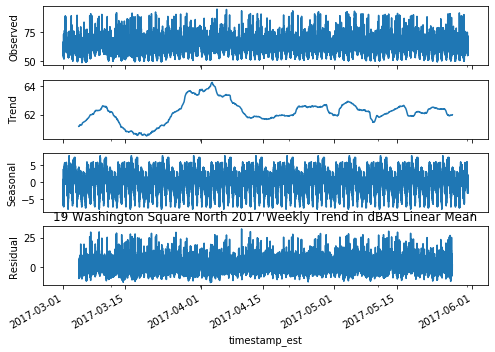

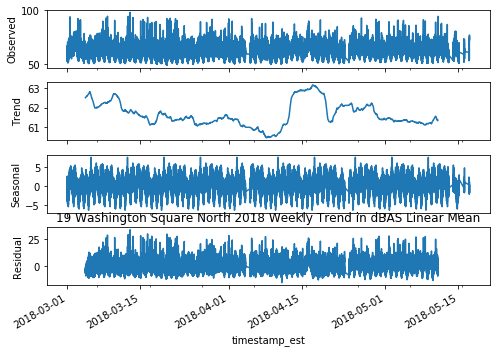

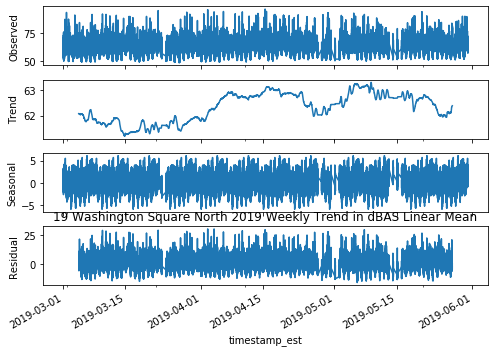

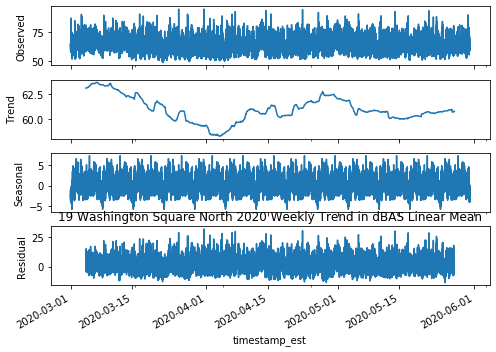

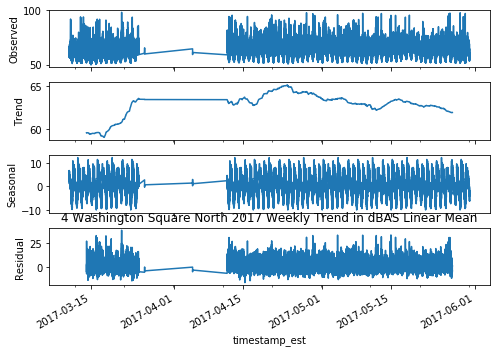

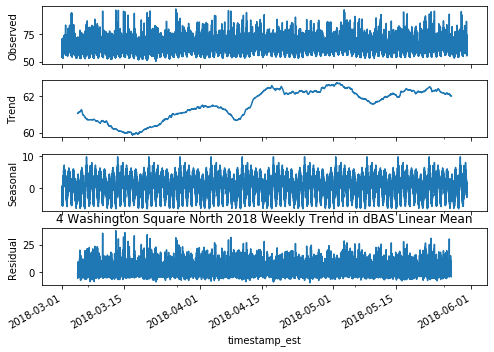

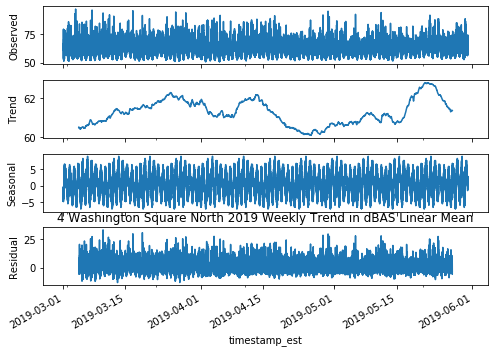

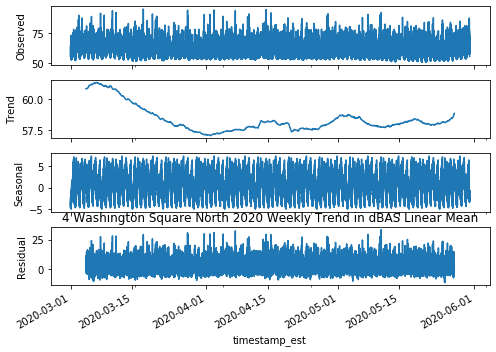

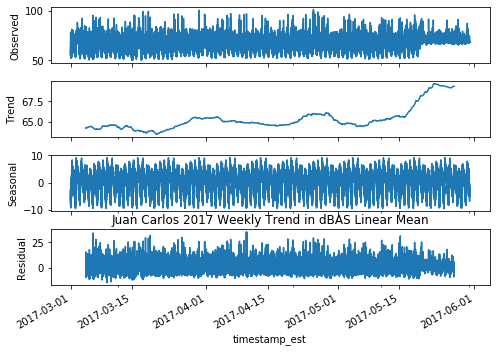

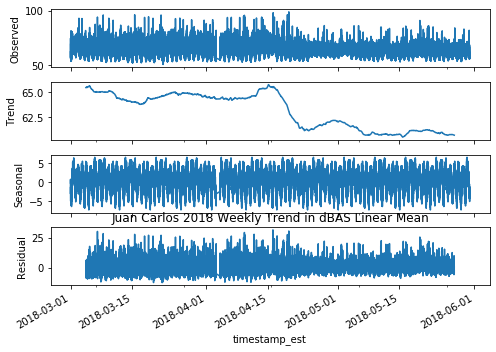

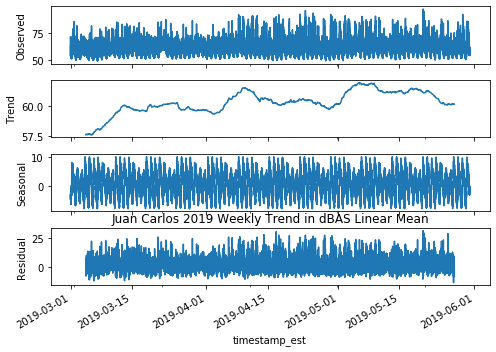

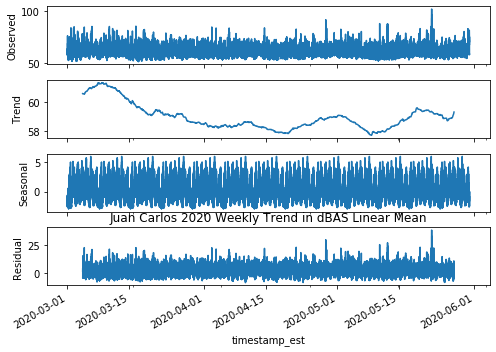

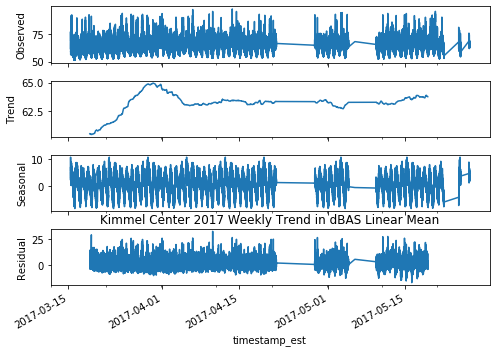

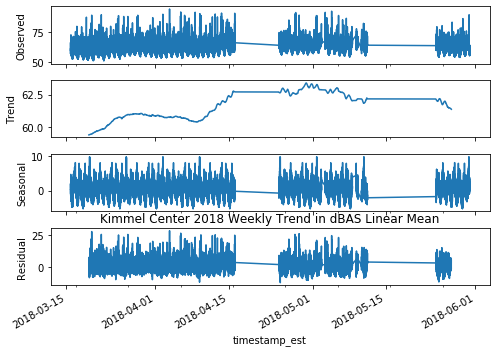

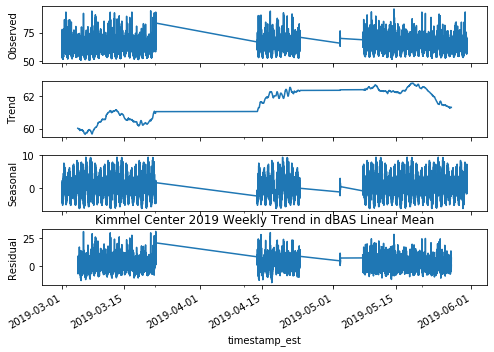

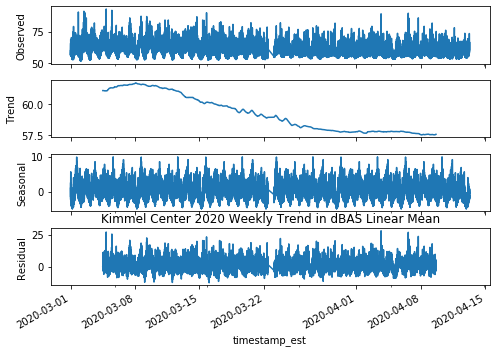

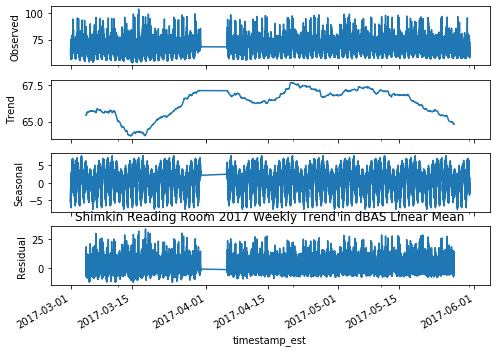

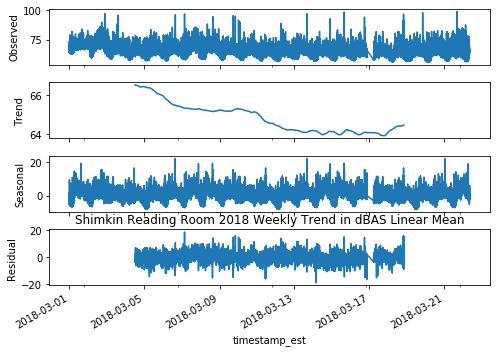

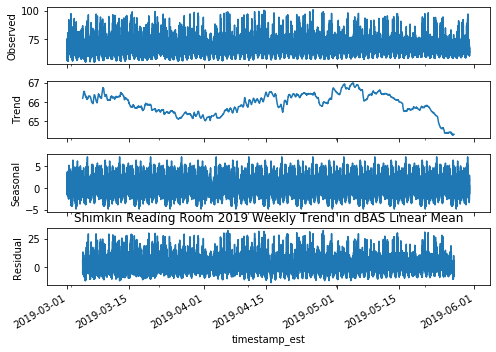

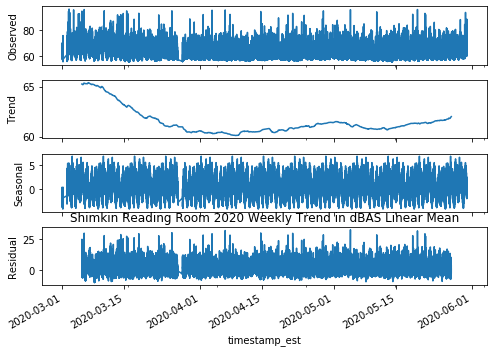

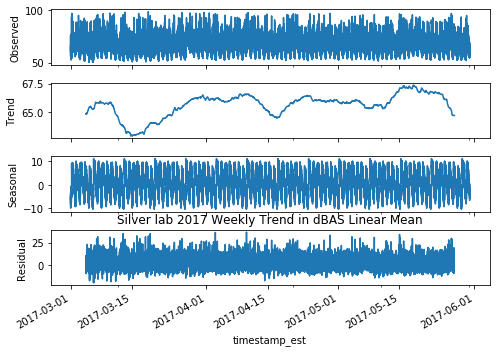

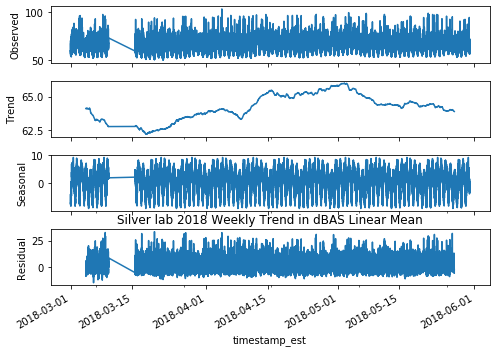

ValueError: operands could not be broadcast together with shapes (1011,) (19151,) 

In [40]:
for key in spring_df_list.keys():
    for yr in [2017, 2018, 2019, 2020]:
        ts = spring_df_list[key][spring_df_list[key].year_est==yr]
        res = sm.tsa.seasonal_decompose(ts['dBAS_lin_mean'], model='additive', freq=7*24*60)
        res.plot()
        plt.title(key +" "+ str(yr) +" Weekly Trend in dBAS Linear Mean")
        plt.show()

In [ ]:
ts = spring_df_list['Juan Carlos'][spring_df_list['Juan Carlos'].year_est==2017]
res = sm.tsa.seasonal_decompose(ts['dBAS_lin_mean'], model='additive', freq=7*24*60)
res.plot()
plt.show()

In [ ]:
ts = spring_df_list['Juan Carlos'][spring_df_list['Juan Carlos'].year_est==2018]
res = sm.tsa.seasonal_decompose(ts['dBAS_lin_mean'], model='additive', freq=7*24*60)
res.plot()
plt.show()

In [ ]:
ts = spring_df_list['Juan Carlos'][spring_df_list['Juan Carlos'].year_est==2019]
res = sm.tsa.seasonal_decompose(ts['dBAS_lin_mean'], model='additive', freq=7*24*60)
res.plot()
plt.show()

In [ ]:
ts = spring_df_list['Juan Carlos'][spring_df_list['Juan Carlos'].year_est==2020]
res = sm.tsa.seasonal_decompose(ts['dBAS_lin_mean'], model='additive', freq=7*24*60)
res.plot()
plt.show()